[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code here follows the [TensorFlow](https://www.tensorflow.org/) implementation by Mark Chang found [here](https://github.com/ckmarkoh/neuralart_tensorflow).

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
from skimage.transform import resize
from tensorflow.python.framework import ops
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vggmodelfile = 'imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(os.path.join('.', vggmodelfile)):
    import six.moves.urllib.request as request
    # use `dl=1` as part of query to force a download
    origin = ('https://www.dropbox.com/s/qy9gikdpuq95w8n/%s?dl=1' % vggmodelfile)
    print('Downloading VGG16 model from: %s' % origin)
    request.urlretrieve(origin, vggmodelfile)
else:
    print('VGG19 model', vggmodelfile, 'is available.')

VGG19 model imagenet-vgg-verydeep-19.mat is available.


In [3]:
out_dir = './results'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [4]:
image_dir = './images'
source_image = 'MALcloudGate2560x1600.jpg'
style_image = 'impressionist.jpg'

source = os.path.join(image_dir, source_image)
style = os.path.join(image_dir, style_image)

if os.path.isdir(image_dir):
    print('Image directory is ready...')
else:
    os.makedirs(image_dir)
        
if os.path.exists(source):
    print('Source image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/9cosz20ijl4xerm/%s?dl=1' % source_image)
    print('Downloading source image from: %s' % origin)
    request.urlretrieve(origin, source)

if os.path.exists(style):
    print('Style image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/8frdjcgf7vnjosx/%s?dl=1' % style_image)
    print('Downloading style image from: %s' % origin)
    request.urlretrieve(origin, style)

Image directory is ready...
Source image exists...
Style image exists...


In [5]:
# some global vars for training
INI_NOISE_RATIO = 0.7
STYLE_STRENGTH = 500
ITERATION = 100

In [6]:
def imshow_clean(img, interpolation=None):
    fig = plt.figure()
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(img, interpolation=interpolation)
    return im

0 255
(1600, 2560, 3)


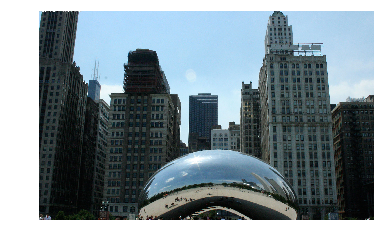

In [7]:
source_data = plt.imread(source)
imshow_clean(source_data)
print(np.min(source_data), np.max(source_data))
print(source_data.shape)

0 255
(1200, 1920, 3)


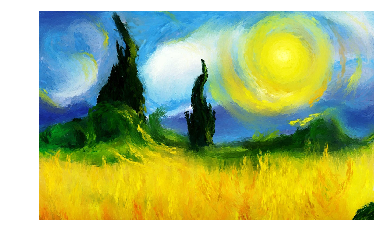

In [8]:
style_data = plt.imread(style)
imshow_clean(style_data)
print(np.min(style_data), np.max(style_data))
print(style_data.shape)

In TensorFlow, image tensor shapes should be : `N x H x W x NChannels`. We will be using a pre-trained VGG16 model here, so we need to resize our images appropriately. In order to use the VGG model, we will also need to subtract the mean of the training dataset for that model.

In [9]:
IMAGE_W = 800   # 1.333 aspect ratio
IMAGE_H = 600
VGG_MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

(1200, 1600, 3)
[28 28 29 29 30 29 29 29 28 29]


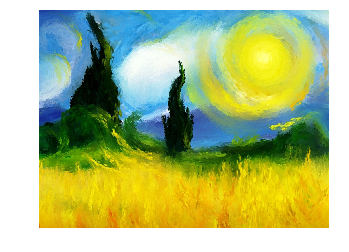

In [10]:
style_clipped = style_data[:,160:1760,:]   # 1200 * 1.333 ~ 1600, take center clip
print(style_clipped.shape)
print(style_clipped[0:10,0,0])
imshow_clean(style_clipped)

If you have to `resize` an image, the elements are re-scaled into the range $[0, 1]$. Be careful to scale back to 0 to 255.

(1, 600, 800, 3)
[ 28.25  29.25  29.5   29.25  28.25  34.    37.    36.    31.    35.75]


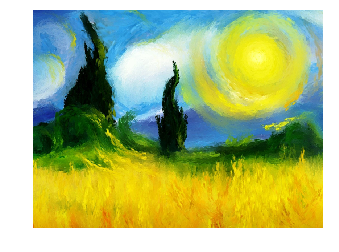

In [11]:
style_resized = 255. * resize(style_clipped, (IMAGE_H, IMAGE_W, 3))
# we need to use a 4-tensor
style_resized = np.reshape(style_resized, (1, IMAGE_H, IMAGE_W, 3))
print(np.shape(style_resized))
print(style_resized[0,0:10,0,0])
imshow_clean(style_resized[0].astype('uint8'))

-123.0 151.0


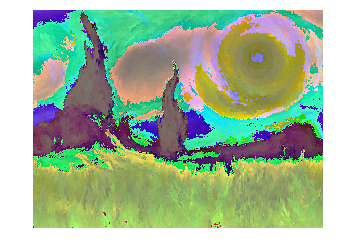

In [12]:
style_normalized = style_resized - VGG_MEAN_VALUES
print(np.min(style_normalized), np.max(style_normalized))
imshow_clean(style_normalized[0].astype('int8'))

0.0 255.0


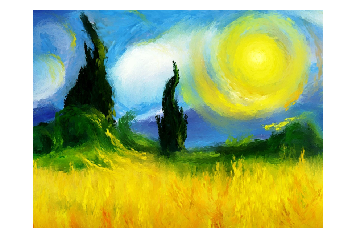

In [13]:
print(np.min(style_normalized + VGG_MEAN_VALUES), np.max(style_normalized + VGG_MEAN_VALUES))
imshow_clean((style_normalized + VGG_MEAN_VALUES)[0].astype('uint8'))

(1600, 2132, 3)
[ 41  16  20  17  22  20  10  57 175 247]


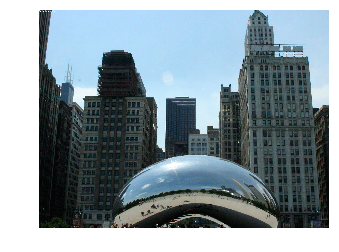

In [14]:
source_clipped = source_data[:,214:2346,:]    # 1600 * 1.333 ~ 2132, take center clip
print(source_clipped.shape)
print(source_clipped[0:10,0,0])
imshow_clean(source_clipped)

(1, 600, 800, 3)
[  16.28166667   26.9925      211.94458333  112.6225       47.12875
   55.69708333   59.005        58.84         64.83666667   67.665     ]


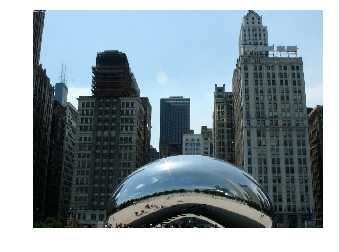

In [15]:
source_resized = 255. * resize(source_clipped, (IMAGE_H, IMAGE_W, 3))
# we need to use a 4-tensor
source_resized = np.reshape(source_resized, (1, IMAGE_H, IMAGE_W, 3))
print(np.shape(source_resized))
print(source_resized[0,0:10,0,0])
imshow_clean(source_resized[0].astype('uint8'))

-123.0 151.0


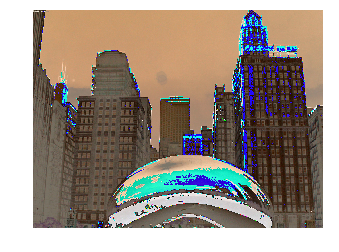

In [16]:
source_normalized = source_resized - VGG_MEAN_VALUES
print(np.min(source_normalized), np.max(source_normalized))
imshow_clean(source_normalized[0].astype('int8'))

0.0 255.0


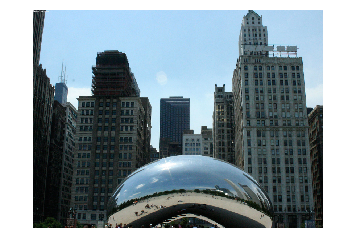

In [17]:
print(np.min(source_normalized + VGG_MEAN_VALUES), np.max(source_normalized + VGG_MEAN_VALUES))
imshow_clean((source_normalized + VGG_MEAN_VALUES)[0].astype('uint8'))

In [18]:
# rename for convenience / simplicity
source_img = source_normalized
style_img = style_normalized

In [19]:
CONTENT_LAYERS = [('conv4_2', 1.)]
STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.), ('conv4_1', 1.), ('conv5_1', 1.)]

In [20]:
def build_net(ntype, nin, rwb=None):
    """
    utility function for building network layers
    * ntype == network layer type
    * nin == network input layer
    """
    # `strides` basically describe how far the kernel steps in each tensor dimension
    # `ksize` describes the size of the pooling region
    # If we use `SAME` padding, the filter is allowed to go off the edge by half the filter size on each side,
    # so we would expect an unchanged image size with stride=1 and a (1/2)x(1/2) for stride=2.
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, rwb[0], strides=[1, 1, 1, 1], padding='SAME') + rwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Padding is explained in the TF [documentation for convolution](https://www.tensorflow.org/api_docs/python/nn/convolution#convolution). 

Let's demonstrate it with the pooling operation:

In [21]:
# X shape of None x 6 x 6 x 1 -> any number of 6x6 tensors that are "1-deep" (e.g., grayscale)
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

TensorFlow separates graph definition and computation into two steps - we must execute operations within a _Session_.

In [22]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We need to pass a tensor with actual data into our "graph" to see how it works.

In [23]:
X_vals = np.arange(6*6).reshape(1, 6, 6, 1)
print(X_vals)

[[[[ 0]
   [ 1]
   [ 2]
   [ 3]
   [ 4]
   [ 5]]

  [[ 6]
   [ 7]
   [ 8]
   [ 9]
   [10]
   [11]]

  [[12]
   [13]
   [14]
   [15]
   [16]
   [17]]

  [[18]
   [19]
   [20]
   [21]
   [22]
   [23]]

  [[24]
   [25]
   [26]
   [27]
   [28]
   [29]]

  [[30]
   [31]
   [32]
   [33]
   [34]
   [35]]]]


In [24]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [25]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [26]:
ops.reset_default_graph()

<img src='./poolig_examp.png'>

Let's look at a different stride to see if the pooling ops behave differently:

In [27]:
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')

In [28]:
# we are using the default graph, so we have to re-initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [29]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 6, 6, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]
   [  8. ]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]
   [ 14. ]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]
   [ 20. ]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]
   [ 26. ]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]
   [ 32. ]]

  [[ 30.5]
   [ 31.5]
   [ 32.5]
   [ 33.5]
   [ 34.5]
   [ 35. ]]]]


In [30]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 5, 5, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]]]]


Ok, with that demo over, let's reset the graph. Before we do, we can inspect it:

In [31]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'AvgPool', 'AvgPool_1', 'init']

In [32]:
ops.reset_default_graph()

In [33]:
[op.name for op in tf.get_default_graph().get_operations()]

[]

In [34]:
def get_weight_bias(vgg_layers, i):
    """
    utility function to get weights and bias values from the layers of our pre-built vgg19 model;
    we set the weights as `constant` to indicate they should not be trainable.
    """
    weights = vgg_layers[i][0][0][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias

In [35]:
def build_vgg19(path):
    """
    build the VGG DNN
    """
    net = {}
    vgg_rawnet = scipy.io.loadmat(path)
    vgg_layers = vgg_rawnet['layers'][0]
    net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
    net['conv1_1'] = build_net('conv', net['input'], get_weight_bias(vgg_layers, 0))
    net['conv1_2'] = build_net('conv', net['conv1_1'], get_weight_bias(vgg_layers, 2))
    net['pool1'] = build_net('pool', net['conv1_2'])
    net['conv2_1'] = build_net('conv', net['pool1'], get_weight_bias(vgg_layers, 5))
    net['conv2_2'] = build_net('conv', net['conv2_1'], get_weight_bias(vgg_layers, 7))
    net['pool2'] = build_net('pool', net['conv2_2'])
    net['conv3_1'] = build_net('conv', net['pool2'], get_weight_bias(vgg_layers, 10))
    net['conv3_2'] = build_net('conv', net['conv3_1'], get_weight_bias(vgg_layers, 12))
    net['conv3_3'] = build_net('conv', net['conv3_2'], get_weight_bias(vgg_layers, 14))
    net['conv3_4'] = build_net('conv', net['conv3_3'], get_weight_bias(vgg_layers, 16))
    net['pool3'] = build_net('pool', net['conv3_4'])
    net['conv4_1'] = build_net('conv', net['pool3'], get_weight_bias(vgg_layers, 19))
    net['conv4_2'] = build_net('conv', net['conv4_1'], get_weight_bias(vgg_layers, 21))
    net['conv4_3'] = build_net('conv', net['conv4_2'], get_weight_bias(vgg_layers, 23))
    net['conv4_4'] = build_net('conv', net['conv4_3'], get_weight_bias(vgg_layers, 25))
    net['pool4'] = build_net('pool', net['conv4_4'])
    net['conv5_1'] = build_net('conv', net['pool4'], get_weight_bias(vgg_layers, 28))
    net['conv5_2'] = build_net('conv', net['conv5_1'], get_weight_bias(vgg_layers, 30))
    net['conv5_3'] = build_net('conv', net['conv5_2'], get_weight_bias(vgg_layers, 32))
    net['conv5_4'] = build_net('conv', net['conv5_3'], get_weight_bias(vgg_layers, 34))
    net['pool5'] = build_net('pool', net['conv5_4'])
    return net

In [36]:
def gram_matrix(x, area, depth):
    """
    input/evaluate with TF tensors
    """
    x1 = tf.reshape(x, (area, depth))
    g = tf.matmul(tf.transpose(x1), x1)
    return g

In [37]:
def gram_matrix_val(x, area, depth):
    """
    numpy version of the `gram_matrix` method (may be evaluated outside a TF `Session`)
    """
    x1 = x.reshape(area, depth)
    g = np.dot(x1.T, x1)
    return g

In [38]:
def build_content_loss(p, x):
    M = p.shape[1] * p.shape[2]
    N = p.shape[3]
    loss = (1. / (2 * N**0.5 * M**0.5)) * tf.reduce_sum(tf.pow((x - p), 2))
    return loss

In [39]:
def build_style_loss(a, x):
    M = a.shape[1] * a.shape[2]
    N = a.shape[3]
    A = gram_matrix_val(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1. / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

Now, with helper functions set, let's perform the style transfer.

In [40]:
net = build_vgg19(vggmodelfile)

In [41]:
[op.name for op in tf.get_default_graph().get_operations()]

['Variable/initial_value',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'Const',
 'Const_1',
 'Conv2D',
 'add',
 'Relu',
 'Const_2',
 'Const_3',
 'Conv2D_1',
 'add_1',
 'Relu_1',
 'AvgPool',
 'Const_4',
 'Const_5',
 'Conv2D_2',
 'add_2',
 'Relu_2',
 'Const_6',
 'Const_7',
 'Conv2D_3',
 'add_3',
 'Relu_3',
 'AvgPool_1',
 'Const_8',
 'Const_9',
 'Conv2D_4',
 'add_4',
 'Relu_4',
 'Const_10',
 'Const_11',
 'Conv2D_5',
 'add_5',
 'Relu_5',
 'Const_12',
 'Const_13',
 'Conv2D_6',
 'add_6',
 'Relu_6',
 'Const_14',
 'Const_15',
 'Conv2D_7',
 'add_7',
 'Relu_7',
 'AvgPool_2',
 'Const_16',
 'Const_17',
 'Conv2D_8',
 'add_8',
 'Relu_8',
 'Const_18',
 'Const_19',
 'Conv2D_9',
 'add_9',
 'Relu_9',
 'Const_20',
 'Const_21',
 'Conv2D_10',
 'add_10',
 'Relu_10',
 'Const_22',
 'Const_23',
 'Conv2D_11',
 'add_11',
 'Relu_11',
 'AvgPool_3',
 'Const_24',
 'Const_25',
 'Conv2D_12',
 'add_12',
 'Relu_12',
 'Const_26',
 'Const_27',
 'Conv2D_13',
 'add_13',
 'Relu_13',
 'Const_28',
 'Const_29',
 'Conv2D

In [42]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [43]:
noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')

In [44]:
sess.run([net['input'].assign(source_img)])
cost_source = sum(
    map(lambda l,: l[1] * build_content_loss(sess.run(net[l[0]]), net[l[0]]), CONTENT_LAYERS)
)

In [45]:
sess.run([net['input'].assign(style_img)])
cost_style = sum(
    map(lambda l,: l[1] * build_style_loss(sess.run(net[l[0]]), net[l[0]]), STYLE_LAYERS)
)

In [46]:
STYLE_STRENGTH = 250

In [47]:
cost_total = cost_source + STYLE_STRENGTH * cost_style
optimizer = tf.train.AdamOptimizer(learning_rate=2.0)
train = optimizer.minimize(cost_total)

In [48]:
print(np.min(1. * source_img), np.max(1. * source_img))

-123.0 151.0


noise image :  -20.0 20.0
source image:  -123.0 151.0
src+vgg img :  0.0 255.0
combo image :  -50.846805954 59.2885015488
cmb+vgg img :  59.072895752 176.516276932


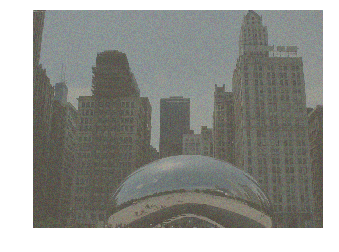

In [49]:
INI_NOISE_RATIO = 0.7
initial_img = INI_NOISE_RATIO * noise_img + (1. - INI_NOISE_RATIO) * source_img
print('noise image : ', np.min(noise_img), np.max(noise_img))
print('source image: ', np.min(source_img), np.max(source_img))
print('src+vgg img : ', np.min(source_img + VGG_MEAN_VALUES), np.max(source_img + VGG_MEAN_VALUES))
print('combo image : ', np.min(initial_img[0]), np.max(initial_img[0]))
print('cmb+vgg img : ', np.min((initial_img + VGG_MEAN_VALUES)[0]), np.max((initial_img + VGG_MEAN_VALUES)[0]))
imshow_clean((initial_img + VGG_MEAN_VALUES)[0].astype('uint8'))

In [50]:
sess.run(tf.initialize_all_variables())
sess.run(net['input'].assign(initial_img))

array([[[[-29.16795349, -26.00126076, -28.17088127],
         [-32.99588394, -29.56964874, -15.35944653],
         [-26.57073593, -18.76732445,  -1.19697511],
         ..., 
         [ 21.50614738,  19.9889679 ,  48.00429916],
         [ 14.19217491,  21.43842697,  46.54072571],
         [ 22.55797386,  28.68879128,  52.02423859]],

        [[-38.04598999, -21.49749756, -12.98351002],
         [ 11.0580759 ,  23.02666664,  14.65818977],
         [-29.31304359,  -7.34474516, -13.24466324],
         ..., 
         [  3.36827397,  12.71386242,  31.26918793],
         [ 10.03720856,  38.62699127,  53.99884033],
         [  4.52830648,  17.66629791,  34.96918106]],

        [[ 25.65140152,  31.72391319,  29.45330238],
         [ 11.42670441,  -1.25938594,  14.74664974],
         [ -3.01538539, -17.21981812,  -5.44091177],
         ..., 
         [ 22.63528633,  36.46030045,  26.77524376],
         [ 18.31066895,  28.2361145 ,  48.36501694],
         [ 11.25000286,  33.0142746 ,  40.09769821

In [51]:
sess.run(train)

(1, 600, 800, 3)
-52.8468 61.2885
57.07289505 178.516277313


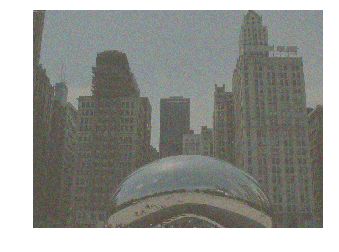

In [52]:
result_image = sess.run(net['input'])
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

In [53]:
for i in range(50):
    print(i)
    sess.run(train)
    result_image = sess.run(net['input'])
    print(sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

0
5.73623e+11
55.1717453003 180.51820755
1
5.26498e+11
53.1830978394 182.514167786
2
4.83219e+11
51.1868515015 184.518367767
3
4.4436e+11
49.179107666 186.50881958
4
4.10397e+11
47.1675300598 188.444450378
5
3.81135e+11
45.1854667664 190.339355469
6
3.55608e+11
43.2521972656 192.199409485
7
3.32921e+11
41.3700485229 194.022315979
8
3.12894e+11
39.5248260498 195.793434143
9
2.95729e+11
37.7167282104 197.504737854
10
2.81394e+11
35.9551544189 199.141815186
11
2.69573e+11
34.1302032471 200.717658997
12
2.59772e+11
32.1457366943 202.232376099
13
2.51416e+11
30.1156539917 203.696731567
14
2.43962e+11
28.1326141357 205.530975342
15
2.37004e+11
26.2106933594 207.52771759
16
2.30281e+11
24.1943511963 209.514526367
17
2.23665e+11
22.1549987793 211.500007629
18
2.17119e+11
20.1405944824 213.492095947
19
2.10666e+11
18.1589355469 215.486213684
20
2.04337e+11
16.2035827637 217.477714539
21
1.98181e+11
14.27368927 219.454956055
22
1.92179e+11
12.3707809448 221.414672852
23
1.86309e+11
10.4423828125

(1, 600, 800, 3)
-143.164 154.34
-39.1640777588 266.731307983


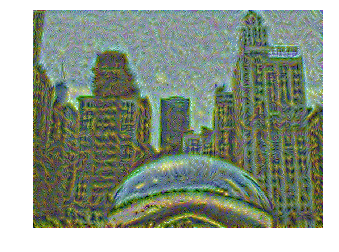

In [54]:
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

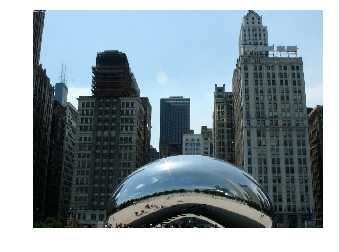

In [55]:
imshow_clean(source_resized[0].astype('uint8'))

In [56]:
for i in range(50, 150):
    print(i)
    sess.run(train)
    result_image = sess.run(net['input'])
    print(sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

50
8.81433e+10
-40.8325805664 268.376602173
51
8.61329e+10
-42.4163970947 269.993041992
52
8.41984e+10
-43.9298400879 271.57421875
53
8.23349e+10
-45.3672180176 273.114746094
54
8.05379e+10
-46.7398681641 274.608688354
55
7.8803e+10
-48.2792510986 276.064483643
56
7.71263e+10
-49.7827911377 277.485275269
57
7.55076e+10
-51.55519104 278.864349365
58
7.39441e+10
-54.1239471436 280.197845459
59
7.24352e+10
-56.7125244141 281.487243652
60
7.0978e+10
-59.3020935059 282.730377197
61
6.95678e+10
-61.8756256104 283.924560547
62
6.82024e+10
-64.417755127 285.302139282
63
6.68793e+10
-66.9219970703 286.766906738
64
6.5598e+10
-69.3772888184 288.178039551
65
6.43558e+10
-71.7579956055 289.547195435
66
6.31525e+10
-74.0603790283 290.883392334
67
6.19855e+10
-76.2748413086 292.18951416
68
6.08518e+10
-78.4034423828 293.467391968
69
5.9751e+10
-80.4390869141 294.7394104
70
5.86812e+10
-82.3792419434 295.996795654
71
5.76406e+10
-84.2151947021 297.250839233
72
5.66282e+10
-85.93699646 298.491744995
7

(1, 600, 800, 3)
-266.317 249.745
-162.316589355 353.744522095


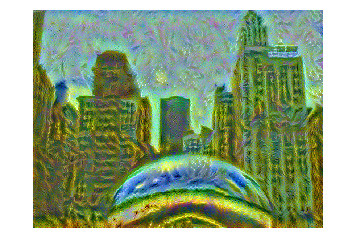

In [57]:
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 